In [3]:
# ============================================================
# PINN para lahar acoplado: (h,u,v,C,p,zb) en 2D + tiempo
# 6 PDE: masa, 2 momento, C, p, Exner
# Incluye 3 topografías y parámetros realistas (prototipo)
# ============================================================


import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, optimizers
import matplotlib.pyplot as plt


tf.random.set_seed(7)
np.random.seed(7)


# --------------------------
# 0) Selección de topografía
# --------------------------
TOPO_SCENARIO = 2  # 1: plano inclinado, 2: valle gaussiano, 3: canal sinuoso

2026-01-08 14:34:00.213651: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-08 14:34:00.221443: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-08 14:34:00.312582: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-08 14:34:00.402656: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767893640.482770    7614 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767893640.50

In [4]:
# --------------------------
# 1) Parámetros físicos
# --------------------------
g = 9.81
rho_m = 1800.0   # kg/m^3 (mezcla densa)
mu0 = 0.20       # fricción base
alpha_C = 1.2    # sensibilidad a concentración
alpha_p = 4.0    # sensibilidad a presión de poros (adimensional)
C0 = 0.45        # concentración referencia
p_ref = 1e4      # Pa (regularización)


kappa_C = 5.0    # m^2/s (difusividad efectiva)
tau_C = 1e9      # s (sin relajación efectiva en prototipo)


tau_p = 120.0    # s (relajación poros)
chi_p = 0.35     # factor para p_eq
u_star = 1.0     # m/s (suavizado)
C_star = 0.05


lambda_por = 0.35  # porosidad del lecho
gamma_s = 0.8      # transporte sólido en Exner
beta_e = 1e-5      # 1/s (erosión)
beta_d = 5e-5      # 1/s (deposición)


eps_u = 1e-3       # para evitar división por cero
eps_h = 1e-6       # para evitar división por cero

In [5]:
# --------------------------
# 2) Dominio (realista prototipo)
# --------------------------
Lx = 10_000.0
Ly = 2_000.0
Tmax = 1_200.0


x_min, x_max = 0.0, Lx
y_min, y_max = -Ly/2, Ly/2
t_min, t_max = 0.0, Tmax


# Normalización (crucial en PINNs)
x_scale = Lx
y_scale = Ly/2
t_scale = Tmax
h_scale = 10.0                  # m (escala típica)
u_scale = 10.0                  # m/s
p_scale = rho_m*g*h_scale        # Pa (orden hidrostático)

In [6]:
# --------------------------
# 3) Topografías (tres escenarios): z_b0(x,y)
# --------------------------
def zb0_physical(x, y):
    """
    x, y en metros, tensores (N,1)
    devuelve z_b0 en metros
    """
    if TOPO_SCENARIO == 1:
        # 1) Plano inclinado con pendiente ~ 0.10 (10%)
        Sx = 0.10
        z0 = 3000.0
        return z0 - Sx * x


    elif TOPO_SCENARIO == 2:
        # 2) Valle gaussiano: pendiente moderada + depresión central
        Sx = 0.06
        z0 = 2900.0
        valley_depth = 120.0
        sigma_y = 350.0
        return (z0 - Sx * x) - valley_depth * tf.exp(-(y**2)/(2*sigma_y**2))


    else:
        # 3) Canal sinuoso: pendiente + ondulación
        Sx = 0.07
        z0 = 2950.0
        A1 = 25.0
        A2 = 15.0
        kx = 2*np.pi/2500.0
        ky = 2*np.pi/800.0
        return (z0 - Sx * x) + A1*tf.sin(kx*x) - A2*tf.cos(ky*y)

In [7]:
# --------------------------
# 4) Condiciones iniciales sintéticas
# --------------------------
def ic_h_physical(x, y):
    x0, y0 = 1200.0, 0.0
    sigx, sigy = 900.0, 450.0
    h0 = 8.0  # m
    return h0 * tf.exp(-((x-x0)**2/(2*sigx**2) + (y-y0)**2/(2*sigy**2)))


def ic_u_physical(x, y): return tf.zeros_like(x)
def ic_v_physical(x, y): return tf.zeros_like(y)


def ic_C_physical(x, y):
    C_bg = 0.35
    C_peak = 0.25
    x0, y0 = 1200.0, 0.0
    sigx, sigy = 1000.0, 550.0
    C = C_bg + C_peak*tf.exp(-((x-x0)**2/(2*sigx**2) + (y-y0)**2/(2*sigy**2)))
    return tf.clip_by_value(C, 0.2, 0.75)


def ic_p_physical(x, y):
    return 0.2 * rho_m * g * ic_h_physical(x, y)


def ic_zb_physical(x, y):
    return zb0_physical(x, y)

In [8]:
# --------------------------
# 5) Muestreo de puntos
# --------------------------
N_ic = 4000
N_pde = 30000
N_bc = 4000  # BC lateral opcional (h~0 en y bordes)


# IC (t=0)
x_ic = tf.random.uniform((N_ic,1), x_min, x_max, dtype=tf.float32)
y_ic = tf.random.uniform((N_ic,1), y_min, y_max, dtype=tf.float32)
t_ic = tf.zeros_like(x_ic)


h_ic = ic_h_physical(x_ic, y_ic)
u_ic = ic_u_physical(x_ic, y_ic)
v_ic = ic_v_physical(x_ic, y_ic)
C_ic = ic_C_physical(x_ic, y_ic)
p_ic = ic_p_physical(x_ic, y_ic)
zb_ic = ic_zb_physical(x_ic, y_ic)


# PDE collocation
x_pde = tf.random.uniform((N_pde,1), x_min, x_max, dtype=tf.float32)
y_pde = tf.random.uniform((N_pde,1), y_min, y_max, dtype=tf.float32)
t_pde = tf.random.uniform((N_pde,1), t_min, t_max, dtype=tf.float32)


# BC: bordes laterales (y = y_min/y_max), imponemos h ~ 0 (opcional)
x_bc = tf.random.uniform((N_bc,1), x_min, x_max, dtype=tf.float32)
t_bc = tf.random.uniform((N_bc,1), t_min, t_max, dtype=tf.float32)
y_bc_top = tf.ones_like(x_bc)*y_max
y_bc_bot = tf.ones_like(x_bc)*y_min

2026-01-08 14:34:03.453966: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [9]:
# --------------------------
# 6) Red neuronal: (x,y,t)->(h,u,v,C,p,zb)
# --------------------------
Cmax = 0.85


inputs = tf.keras.Input(shape=(3,))
x = layers.Dense(96, activation='tanh')(inputs)
x = layers.Dense(96, activation='tanh')(x)
x = layers.Dense(96, activation='tanh')(x)
x = layers.Dense(96, activation='tanh')(x)
out_raw = layers.Dense(6, activation='linear')(x)
model = tf.keras.Model(inputs=inputs, outputs=out_raw)


opt = optimizers.Adam(learning_rate=1e-3)
mse = tf.keras.losses.MeanSquaredError()


@tf.function
def predict_fields(xm, ym, tm):
    # Entradas normalizadas
    xn = xm/x_scale
    yn = ym/y_scale
    tn = tm/t_scale
    inp = tf.concat([xn, yn, tn], axis=1)
    raw = model(inp)


    h_raw = raw[:,0:1]
    u_raw = raw[:,1:2]
    v_raw = raw[:,2:3]
    C_raw = raw[:,3:4]
    p_raw = raw[:,4:5]
    zb_raw = raw[:,5:6]


    # Constraints suaves
    h = tf.nn.softplus(h_raw) * h_scale               # m
    u = u_raw * u_scale                               # m/s
    v = v_raw * u_scale                               # m/s
    C = tf.sigmoid(C_raw) * Cmax                      # [-]
    p = tf.nn.softplus(p_raw) * p_scale               # Pa
    zb = zb_raw * 3000.0                              # m (escala elevación)


    return h, u, v, C, p, zb

In [10]:
# --------------------------
# 7) Cierres
# --------------------------
@tf.function
def mu_eff(C, p, h):
    denom = rho_m*g*h + p_ref
    return mu0*(1.0 + alpha_C*(C - C0)) * tf.exp(-alpha_p * (p/denom))


@tf.function
def cos_theta(zb_x, zb_y):
    return 1.0/tf.sqrt(1.0 + zb_x**2 + zb_y**2)


@tf.function
def p_eq(h, C, u, v):
    speed = tf.sqrt(u**2 + v**2 + eps_u)
    phiC = C/(C + C_star)
    return chi_p * rho_m*g*h * phiC * (speed/(speed + u_star))


@tf.function
def qs(h, C, u, v):
    qx = gamma_s * h * C * u
    qy = gamma_s * h * C * v
    return qx, qy


@tf.function
def EminusD(C, u, v):
    speed = tf.sqrt(u**2 + v**2 + eps_u)
    return beta_e*speed - beta_d*C

In [11]:
# --------------------------
# 8) Residuos PDE (6 ecuaciones) - CORREGIDO
# --------------------------
@tf.function
def pde_residuals(xm, ym, tm):
    """
    Devuelve:
      f_mass, f_momx, f_momy, f_C, f_p, f_zb
    """
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch([xm, ym, tm])
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch([xm, ym, tm])


            h, u, v, C, p, zb = predict_fields(xm, ym, tm)
            H = h + zb


            hu = h*u
            hv = h*v


            # para Exner (debe quedar dentro del grafo)
            qx, qy = qs(h, C, u, v)


        # ---- Derivadas 1er orden
        h_t  = tape1.gradient(h, tm)
        hu_x = tape1.gradient(hu, xm)
        hv_y = tape1.gradient(hv, ym)


        u_t = tape1.gradient(u, tm)
        u_x = tape1.gradient(u, xm)
        u_y = tape1.gradient(u, ym)


        v_t = tape1.gradient(v, tm)
        v_x = tape1.gradient(v, xm)
        v_y = tape1.gradient(v, ym)


        H_x = tape1.gradient(H, xm)
        H_y = tape1.gradient(H, ym)


        C_t = tape1.gradient(C, tm)
        C_x = tape1.gradient(C, xm)
        C_y = tape1.gradient(C, ym)


        p_t = tape1.gradient(p, tm)
        p_x = tape1.gradient(p, xm)
        p_y = tape1.gradient(p, ym)


        zb_t = tape1.gradient(zb, tm)


    # ---- Derivadas 2do orden (usando tape2 sobre derivadas de tape1)
    # Topografía
    zb_x = tape2.gradient(zb, xm)
    zb_y = tape2.gradient(zb, ym)


    # Difusión C
    C_xx = tape2.gradient(C_x, xm)
    C_yy = tape2.gradient(C_y, ym)


    # Exner: divergencia de q_s
    qx_x = tape2.gradient(qx, xm)
    qy_y = tape2.gradient(qy, ym)


    del tape1
    del tape2


    # (1) Masa mezcla
    S_h = 0.0
    f_mass = h_t + hu_x + hv_y - S_h


    # Fricción basal
    speed = tf.sqrt(u**2 + v**2 + eps_u)
    mu = mu_eff(C, p, h)
    cth = cos_theta(zb_x, zb_y)


    tau_b  = mu * rho_m * g * h * cth
    tau_bx = tau_b * (u/(speed + eps_u))
    tau_by = tau_b * (v/(speed + eps_u))


    # (2-3) Momento (forma no conservativa, prototipo)
    denom_h = rho_m*(h + eps_h)
    f_momx = u_t + u*u_x + v*u_y + g*H_x + tau_bx/denom_h
    f_momy = v_t + u*v_x + v*v_y + g*H_y + tau_by/denom_h


    # (4) Concentración (advección-difusión + relajación)
    C_eq_val = 0.45
    f_C = C_t + u*C_x + v*C_y - (kappa_C*(C_xx + C_yy) + (C_eq_val - C)/tau_C)


    # (5) Presión de poros (advección + relajación)
    peq = p_eq(h, C, u, v)
    f_p = p_t + u*p_x + v*p_y - (peq - p)/tau_p


    # (6) Exner
    EmD = EminusD(C, u, v)
    f_zb = zb_t + (1.0/(1.0 - lambda_por))*(qx_x + qy_y) - EmD


    return f_mass, f_momx, f_momy, f_C, f_p, f_zb

In [12]:
# --------------------------
# 9) Pérdidas IC y BC
# --------------------------
@tf.function
def loss_ic():
    h_pred,u_pred,v_pred,C_pred,p_pred,zb_pred = predict_fields(x_ic, y_ic, t_ic)
    L = 0.0
    L += mse(h_ic, h_pred)
    L += mse(u_ic, u_pred)
    L += mse(v_ic, v_pred)
    L += mse(C_ic, C_pred)
    L += mse(p_ic, p_pred)
    # topografía inicial fuerte
    L += 5.0*mse(zb_ic, zb_pred)
    return L


@tf.function
def loss_bc():
    # BC lateral: h ~ 0 en y bordes (opcional; pon lambda_BC=0 si no lo quieres)
    h_top,_,_,_,_,_ = predict_fields(x_bc, y_bc_top, t_bc)
    h_bot,_,_,_,_,_ = predict_fields(x_bc, y_bc_bot, t_bc)
    return mse(tf.zeros_like(h_top), h_top) + mse(tf.zeros_like(h_bot), h_bot)

In [13]:
# --------------------------
# 10) Entrenamiento (mini-batches PDE)
# --------------------------
lambda_IC  = 20.0
lambda_PDE = 1.0
lambda_BC  = 1.0   # si te molesta, pon 0.0


pde_batch = 4096
epochs = 500


@tf.function
def train_step():
    idx = tf.random.uniform((pde_batch,), 0, N_pde, dtype=tf.int32)
    xb = tf.gather(x_pde, idx)
    yb = tf.gather(y_pde, idx)
    tb = tf.gather(t_pde, idx)


    with tf.GradientTape() as tape:
        Lic = loss_ic()
        Lbc = loss_bc()


        f_mass, f_momx, f_momy, f_C, f_p, f_zb = pde_residuals(xb, yb, tb)
        Lpde = (tf.reduce_mean(tf.square(f_mass)) +
                tf.reduce_mean(tf.square(f_momx)) +
                tf.reduce_mean(tf.square(f_momy)) +
                tf.reduce_mean(tf.square(f_C)) +
                tf.reduce_mean(tf.square(f_p)) +
                tf.reduce_mean(tf.square(f_zb)))


        L = lambda_IC*Lic + lambda_PDE*Lpde + lambda_BC*Lbc


    grads = tape.gradient(L, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    return L, Lic, Lpde, Lbc


for ep in range(epochs):
    L, Lic, Lpde, Lbc = train_step()
    if (ep+1) % 200 == 0:
        print(f"Epoch {ep+1}/{epochs} | Total {L.numpy():.3e} | IC {Lic.numpy():.3e} | PDE {Lpde.numpy():.3e} | BC {Lbc.numpy():.3e}")


print("Entrenamiento PINN acoplada para lahares: OK")

Epoch 200/500 | Total 5.138e+08 | IC 2.569e+07 | PDE 9.154e+02 | BC 2.902e+01
Epoch 400/500 | Total 4.450e+08 | IC 2.225e+07 | PDE 3.025e+02 | BC 2.231e+01
Entrenamiento PINN acoplada para lahares: OK


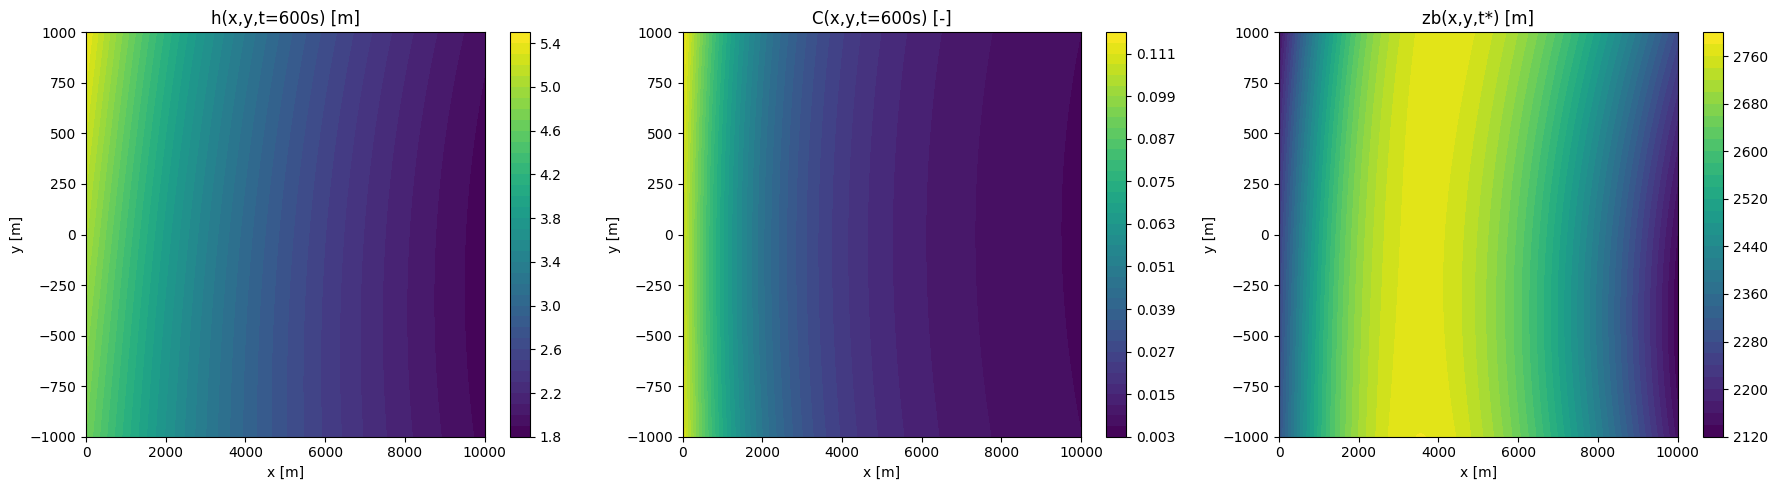

Listo: mapas de h, C y zb en t*.


In [14]:
# --------------------------
# 11) Predicción y visualización de ejemplo en un tiempo t*
# --------------------------
t_star = 600.0
nx, ny = 160, 90
xg = np.linspace(x_min, x_max, nx).astype(np.float32)
yg = np.linspace(y_min, y_max, ny).astype(np.float32)
X, Y = np.meshgrid(xg, yg, indexing='xy')
Xf = X.reshape(-1,1)
Yf = Y.reshape(-1,1)
Tf = np.full_like(Xf, t_star, dtype=np.float32)


h_pred,u_pred,v_pred,C_pred,p_pred,zb_pred = predict_fields(
    tf.convert_to_tensor(Xf), tf.convert_to_tensor(Yf), tf.convert_to_tensor(Tf)
)


h_map  = h_pred.numpy().reshape(ny,nx)
C_map  = C_pred.numpy().reshape(ny,nx)
zb_map = zb_pred.numpy().reshape(ny,nx)


plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.contourf(X, Y, h_map, levels=40)
plt.title(f"h(x,y,t={t_star:.0f}s) [m]")
plt.xlabel("x [m]"); plt.ylabel("y [m]")
plt.colorbar()


plt.subplot(1,3,2)
plt.contourf(X, Y, C_map, levels=40)
plt.title(f"C(x,y,t={t_star:.0f}s) [-]")
plt.xlabel("x [m]"); plt.ylabel("y [m]")
plt.colorbar()


plt.subplot(1,3,3)
plt.contourf(X, Y, zb_map, levels=40)
plt.title("zb(x,y,t*) [m]")
plt.xlabel("x [m]"); plt.ylabel("y [m]")
plt.colorbar()


plt.tight_layout()
plt.show()


print("Listo: mapas de h, C y zb en t*.")